# Modeling

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

### Create a Pipeline

In [2]:
from preprocessing import GPSHeightImputer, LatLongImputer, PopulationImputer, ConstructionYearTransformer, HighCardTransformer, DistrictCodeMerge, ExtractionMerge, MeanPumpTransformer

## Evaluate
What are the most important things to look for with regression?

In [3]:
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline


def plot_confusion_matrix(y_true, y_preds):
    # Print confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_preds)
    
    # Create the basic matrix
    plt.imshow(cnf_matrix,  cmap=plt.cm.Blues)
    # Add title and axis labels
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # Add appropriate axis scales
    class_names = [0, 1, 2]# Get class labels to add to matrix
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=0)
    plt.yticks(tick_marks, class_names)
    # Add labels to each cell
    thresh = cnf_matrix.max() / 2. # Used for text coloring below
    # Here we iterate through the confusion matrix and append labels to our visualization
    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
            plt.text(j, i, cnf_matrix[i, j],
                     horizontalalignment='center',
                     color='white' if cnf_matrix[i, j] > thresh else 'black')
    # Add a legend
    plt.colorbar();
    plt.show();

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

def metrics(model_name, y_train, y_test, y_train_pred, y_test_pred):
    '''Print out the evaluation metrics for a given models predictions'''
    print(f'Model: {model_name}', )
    print('-'*60)
    plot_confusion_matrix(y_test, y_test_pred)
    print('-'*60)
    print(f'test accuracy: {accuracy_score(y_test, y_test_pred)}')
    print(f'train accuracy: {accuracy_score(y_train, y_train_pred)}')
    print('-'*60)
    print('\ntest report:\n' + classification_report(y_test, y_test_pred))
    print('~'*60)
    print('\ntrain report:\n' + classification_report(y_train, y_train_pred))    
    print('-'*60)
    

## Dataset

### Full

In [5]:
# full dataset
X = pd.read_csv('../data/raw/X_train.csv')
y = pd.read_csv('../data/raw/y_train.csv')

X_contest = pd.read_csv('../data/raw/X_test.csv')

In [6]:
X.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [7]:
y['status_group'].value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [8]:
y['status_code'] = y['status_group'].astype('category').cat.codes

In [9]:
y.head()

,id,status_group,status_code
0,69572,functional,0
1,8776,functional,0
2,34310,functional,0
3,67743,non functional,2
4,19728,functional,0


In [10]:
# split full data
X_train, X_test, y_train, y_test = train_test_split(X, y['status_code'], test_size=.2, random_state=42)

# Models
- LinearSVC
- k-NN
- XGBoost
- Random Forest

## LinearSVC

### Why LinearSVC
The objective of a Linear SVC (Support Vector Classifier) is to fit to the data you provide, returning a "best fit"
hyperplane that divides, or categorizes, your data. 

It has more flexibility in the choice of penalties and loss functions and should scale better to large numbers of samples.

LinearSVC is another (faster) implementation of Support Vector Classification for the case of a linear kernel.

### Hyperparameters

In [47]:
lsvc_params = {
    'model__C': [1],
    'model__tol': [1],
    'model__max_iter': [10000],
    'model__dual': [False],
    'model__penalty': ['l1'],
    'model__multi_class': ['crammer_singer']
}

lsvc_params.update(preprocessor_params)
# {'model__C': 1, 'model__dual': False, 'model__max_iter': 10000, 'model__multi_class': 'crammer_singer', 'model__penalty': 'l1',
#     'model__tol': 1, 'preprocessor__high_card__impute__missing_values': nan, 'preprocessor__high_card__impute__strategy': 'mean'}
# Best parameter (CV score=0.630):
# {'model__C': 0.1, 'model__max_iter': 100000, 'model__multi_class': 'crammer_singer', 'model__penalty': 'l1', 'model__tol': 0.1}

In [48]:
lsvc_params

{'model__C': [1],
 'model__tol': [1],
 'model__max_iter': [10000],
 'model__dual': [False],
 'model__penalty': ['l1'],
 'model__multi_class': ['crammer_singer'],
 'preprocessor__gps_transformer__lat_long_imputer__method': ['mean'],
 'preprocessor__gps_transformer__gps_height_imputer__method': ['custom'],
 'preprocessor__gps_transformer__population_imputer__method': ['mean'],
 'preprocessor__construction_year__transform__method': ['custom'],
 'preprocessor__high_card__impute__missing_values': [nan],
 'preprocessor__high_card__impute__strategy': ['most_frequent'],
 'preprocessor__other_high_card__impute__missing_values': [nan],
 'preprocessor__other_high_card__impute__strategy': ['mean'],
 'preprocessor__scheme_management__impute__missing_values': [nan],
 'preprocessor__scheme_management__impute__strategy': ['mean'],
 'preprocessor__scheme_name__impute__missing_values': [nan],
 'preprocessor__scheme_name__impute__strategy': ['mean'],
 'preprocessor__cat__impute__missing_values': [nan],
 

### Fitting LinearSVC

In [41]:
from sklearn.svm import LinearSVC

lsvc = {'model': LinearSVC(random_state=42), 'params': {} }
lsvc_test_preds, lsvc_train_preds, lsvc_pipeline = fit_predict(
    lsvc, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.6s remaining:    5.3s


KeyboardInterrupt: 

Model: LinearSVC
------------------------------------------------------------


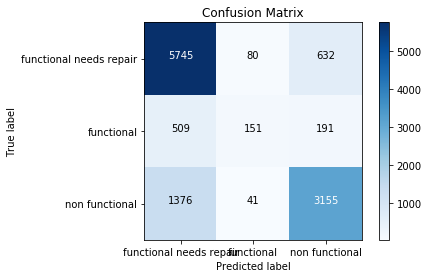

------------------------------------------------------------
test accuracy: 0.7618686868686869
train accuracy: 0.7812920875420876
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.82      6457
           1       0.56      0.18      0.27       851
           2       0.79      0.69      0.74      4572

    accuracy                           0.76     11880
   macro avg       0.70      0.59      0.61     11880
weighted avg       0.75      0.76      0.75     11880

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.77      0.90      0.83     25802
           1       0.64      0.21      0.32      3466
           2       0.82      0.71      0.76     18252

    accuracy                           0.78     47520
   macro avg       0.74      0.61      0.64     47520
weighted avg

In [179]:
metrics('LinearSVC', y_train, y_test, lsvc_train_preds, lsvc_test_preds)

### Evaluating LinearSVC (pre-pipe)

Model: LinearSVC
------------------------------------------------------------


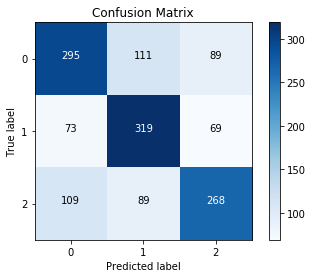

------------------------------------------------------------
test accuracy: 0.620253164556962
train accuracy: 0.6458521870286577
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61       495
           1       0.61      0.69      0.65       461
           2       0.63      0.58      0.60       466

    accuracy                           0.62      1422
   macro avg       0.62      0.62      0.62      1422
weighted avg       0.62      0.62      0.62      1422

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62      1084
           1       0.64      0.71      0.67      1118
           2       0.68      0.60      0.64      1113

    accuracy                           0.65      3315
   macro avg       0.65      0.65      0.64      3315
weighted avg 

In [501]:
# metrics('LinearSVC', y_train, y_test, lsvc_train_preds, lsvc_test_preds)

## KNN

### Why KNN
KNNs are a non-parametric, lazy learning algorithm. It makes no underlying assumptions about the distribution of data. 

No training is necessary! 

KNN makes predictions just-in-time by calculating the similarity between an input sample and each training instance.

It is a Simple algorithm — to explain and understand/interpret. It is versatile — useful for classification or regression.

### Hyperparameters

In [11]:
preprocessor_params =  {
#     'preprocessor__gps_transformer__lat_long_imputer__method': ['mean'],
#     'preprocessor__gps_transformer__gps_height_imputer__method': ['mean'],
#     'preprocessor__gps_transformer__population_imputer__method': ['mean'],
#     'preprocessor__construction_year__transform__method': ['custom'],
# #     'preprocessor__high_card__impute__missing_values': [0, 1],
# #     'preprocessor__high_card__impute__strategy': ['most_frequent'],
# #     'preprocessor__other_high_card__impute__missing_values': [np.nan],
# #     'preprocessor__other_high_card__impute__strategy': ['mean'],
# #     'preprocessor__scheme_management__impute__missing_values': [np.nan],
# #     'preprocessor__scheme_management__impute__strategy': ['mean'],
# #     'preprocessor__scheme_name__impute__missing_values': [np.nan],
# #     'preprocessor__scheme_name__impute__strategy': ['mean'],
#     'preprocessor__cat__impute__missing_values': [np.nan],
#     'preprocessor__cat__impute__strategy': ['most_frequent'],
#     'preprocessor__district_code__impute__missing_values': [np.nan],
#     'preprocessor__district_code__impute__strategy': ['mean'],
#     'preprocessor__extraction__impute__missing_values': [np.nan],
#     'preprocessor__extraction__impute__strategy': ['most_frequent'],
}

In [12]:
knn_params = {
#     'pca__n_components': range(80, 120, 20),
    # amount of neighbors
    'model__n_neighbors': [5],
    # leaf size
    'model__leaf_size': [1],
    'model__weights': ['distance'],
    'model__p': [2]
}

knn_params.update(preprocessor_params)

### Fitting KNN

In [242]:
from sklearn.neighbors import KNeighborsClassifier
knn = { 'model': KNeighborsClassifier(), 'params': knn_params }
knn_test_preds, knn_train_preds, knn_pipeline = fit_predict(knn, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   13.0s remaining:   19.6s


KeyboardInterrupt: 

### Ideas to try
1. distance from cluster of functioning, or distance to cluster of non functioning

### Imputation scores

### GPS Imputations
1. added gps pipeline, using 'custom': .652
2. gps pipeline only, 'mean' impute on population, 'custom' for others: .652
3. gps pipeline only, 'median' impute on population and elevations 'custom' for others: .652
4. gps pipeline only, 'mean' impute on all: .654 <-- faster then using 'custom' as well

### Construction Year Imputations
1. construction_year solo using 'custom': .534 <-- converting to age
2. construction_year solo using 'mean': .478
3. construction_year solo using sklearn 'mean': .478
4. construction_year solo using 'ignore': .501

### High Card Imputations
1. high_card using 'most_frequent': .662
2. high_card using 'mean': .662
3. high_card using 'constant' = -999: .663 <--
4. high_card using 'median': 
5. imputed 1's to 'mean':  .660
6. imputed 1's and 0's to mean: .663 <-- 
7. imputed 0's to mean: .659
8. imputed 1's and 0's using 'median': .656
9. imputed nans as 'constant' -999, imputed 1's and 0's using 'median': .653
10. inputed nans as 'constant' -999, imputed 1's and 0's using 'mean': .663 <--

### Subvillage
1. added subvillage using 1's and 0's to median: .557
2. subvillage imputing nans as mean: .578 <--
3. subvillage impute nans as mean, impute 1's and 0's to mean: .573 

### Funder
1. nan as means: .562
2. nan as means, and 0's and 1's as median: .546
3. nans as means, 0s, 1's as mean: .566 <-- 

### Mean_Pump
1. nan as means: .583
2. nan as median: .584

### Scheme name
1. nans as mean 1's and 0's as mean: .592
2. nans as means: .603 <--

### Scheme management
1. nans as mean 1's and 0's as mean: .503
2. nans as means: .512 <--

### Basin
1. nans imputed as most_frequent: .525
2. nans imputed as 'mean': .525 <-- same, because basin has no nans

### Public Meeting
1. nans imputed as most_frequent: .545 <--
2. nans imputed as constant -1: .544
3. removed onehot since is bool, imputed as constant with -1: .542
4. removed onehot, inputed as most_frequent: .543

### Permit
1. nans imputed as constant -1: .528 <--
2. removed onehot, imputed as most_frequent: .511
3. removed onehot, imputed as constant -1: .525

### Management
1. nans imputed as constant 'unknown: .508
2. nans imputed as most frequent: .508

### Management Group
1. nans imputed as most frequent: .458
2. nans imputed as constant 'unknown': .458

### Payment
1. 'unknown' imputed as most frequent: .510

### Water Quality
1. 'unknown' imputed as most frequent: .512

### Quantity
1. 'unknown' imputed as most frequent: 518
Assuming all categorical values improve when imputing 'unknown' as 'most_frequent'

### District Code
1. nan as means: .56 <--
2. nan as means, and 0's and 1's as median: .542
3. nans as means, 0s, 1's as mean: .543 

### Extraction
1. nans as most_frequent (there should not be any nans): .608
2. without imputing: .608


Ranked Scores:
1. high card: .663
2. gps: .654
3. extraction: .608
4. scheme_name: .603
5. mean_pump: .584
6. subvillage: .573
7. funder: .566
8. district: .56
9. public_meeting: .545
10. year: .534

Forward Selection:
1. high card: .663
2. gps: .687
3. extraction: .723
4. scheme_name: .729
5. mean_pump: .722 <-- bad
6. subvillage: .720 <-- bad
7. funder: .721
8. district: .722
9. public_meeting: .725
10. year: .728
11. funder: .730
12. permit: .730
13. cats: .776
14. without bads: .777

Model: k-NN
------------------------------------------------------------


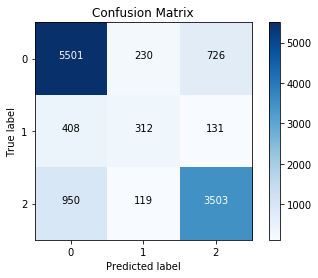

------------------------------------------------------------
test accuracy: 0.7841750841750842
train accuracy: 0.9983796296296297
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.80      0.85      0.83      6457
           1       0.47      0.37      0.41       851
           2       0.80      0.77      0.78      4572

    accuracy                           0.78     11880
   macro avg       0.69      0.66      0.67     11880
weighted avg       0.78      0.78      0.78     11880

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     25802
           1       0.99      0.99      0.99      3466
           2       1.00      1.00      1.00     18252

    accuracy                           1.00     47520
   macro avg       1.00      1.00      1.00     47520
weighted avg

In [232]:
metrics('k-NN', y_train, y_test, knn_train_preds, knn_test_preds)

### Evaluating KNN (pre-pipe)

Model: k-NN
------------------------------------------------------------


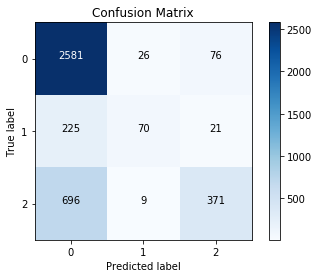

------------------------------------------------------------
test accuracy: 0.7415950920245399
train accuracy: 0.9979749631811488
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.83      2683
           1       0.67      0.22      0.33       316
           2       0.79      0.34      0.48      1076

    accuracy                           0.74      4075
   macro avg       0.73      0.51      0.55      4075
weighted avg       0.75      0.74      0.70      4075

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10729
           1       1.00      0.99      1.00      1263
           2       1.00      0.99      1.00      4304

    accuracy                           1.00     16296
   macro avg       1.00      1.00      1.00     16296
weighted avg

In [676]:
# metrics('k-NN', y_total_train, y_total_test, knn_train_preds, knn_test_preds)

## XGBoost

### Why XGBoost

### Hyperparameters

In [32]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


def fit_predict(model, X_train, X_test, y_train, y_test):
    '''fit pipeline using given model, and return predictions'''
    gps_cols = []
    gps_cols = ['latitude', 'longitude', 'gps_height', 'population', 'ward', 'region', 'basin']
    gps_transformer = Pipeline(steps=[
        ('lat_long_imputer', LatLongImputer(method='custom')),
        ('gps_height_imputer', GPSHeightImputer(method='custom')),
        ('population_imputer', PopulationImputer(method='custom')),
        ('scale', StandardScaler())
    ])

    construction_year_cols = []
    construction_year_cols = ['construction_year', 'date_recorded']
    construction_year_transformer = Pipeline(steps=[
        ('transform', ConstructionYearTransformer(method='custom')),
        ('scale', StandardScaler())
    ])

    scheme_name_cols = []
    scheme_management_cols = []
    scheme_name_cols = ['scheme_name']
    scheme_management_cols = ['scheme_management']
    scheme_transformer = Pipeline(steps=[
        ('transform', HighCardTransformer()),
        ('impute', SimpleImputer(strategy='mean'))
    ])

    high_card_cols = []
    high_card_cols = ['lga'] #  'ward', 'installer'
    high_card_transformer = Pipeline(steps=[
        ('transform', HighCardTransformer()),
        ('impute_nan', SimpleImputer(strategy='constant', fill_value=-999)),
    ])

    other_high_cols = []
#     other_high_cols = ['funder']
    subvillage_cols = []
#     subvillage_cols = ['subvillage']
    subvillage_transformer = Pipeline(steps=[
        ('transform', HighCardTransformer()),
        ('impute_nan', SimpleImputer(strategy='mean')),
        ('impute_zeros', SimpleImputer(strategy='mean', missing_values=0)),
        ('impute_ones', SimpleImputer(strategy='mean', missing_values=1))
    ])

    cat_cols = ['basin', 'management_group', 'payment', 'quantity', 'source', 'waterpoint_type']
#     cat_cols = ['water_quality', 'source_class', 'management']
    cat_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent', missing_values='unknown')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    public_meeting_cols = []
    public_meeting_cols = ['public_meeting']
    public_meeting_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='mean')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    permit_cols = []
#     permit_cols = ['permit']
    permit_transformer = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='constant', fill_value=-1)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    district_code_cols = []
    district_code_cols = ['district_code', 'region']
    district_code_transformer = Pipeline(steps=[
        ('merge', DistrictCodeMerge()),
        ('transform', HighCardTransformer()),
        ('impute', SimpleImputer(strategy='mean')),
        ('impute_zeros', SimpleImputer(strategy='mean', missing_values=0)),
        ('impute_ones', SimpleImputer(strategy='mean', missing_values=1))
    ])

    extraction_cols = []
#     extraction_cols = ['extraction_type',
#                        'extraction_type_group', 'extraction_type_class']
    extraction_transformer = Pipeline(steps=[
        ('merge', ExtractionMerge()),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    mean_pump_cols = []

#     mean_pump_cols = ['latitude', 'longitude']
    mean_pump_transformer = Pipeline(steps=[
        ('transform', MeanPumpTransformer()),
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])

    # Bundle preprocessing for all types of columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('gps_transformer', gps_transformer, gps_cols),
            ('construction_year', construction_year_transformer, construction_year_cols),
            ('high_card', high_card_transformer, high_card_cols),
            ('other_high_card', subvillage_transformer, other_high_cols),
            ('subvillage_transformer', subvillage_transformer, subvillage_cols),
            ('scheme_name', scheme_transformer, scheme_name_cols),
            ('scheme_management', scheme_transformer, scheme_management_cols),
            ('cat', cat_transformer, cat_cols),
            ('public_meeting', public_meeting_transformer, public_meeting_cols),
            ('permit', permit_transformer, permit_cols),
            ('district_code', district_code_transformer, district_code_cols),
            ('extraction', extraction_transformer, extraction_cols),
            ('mean_pump', mean_pump_transformer, mean_pump_cols)
        ])

    param_grid = model['params']
    model = model['model']

    # Bundle preprocessing and modeling code in a pipeline
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('model', model)
                                  ])

    search = GridSearchCV(estimator=my_pipeline, error_score='raise',
                          param_grid=param_grid, n_jobs=-1, verbose=4)

    train_preds = search.fit(X_train, y_train)
    train_preds = search.predict(X_train)
    test_preds = search.predict(X_test)

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

    return test_preds, train_preds, search

In [33]:
xgb_params = {
#     'pca__n_components': range(20, 60, 20),
    'model__colsample_bytree': [.2],       # how many features to use per estimator/tree
    'model__eta': [.01],                   # learning rate
    'model__n_estimators': [500],         # how many models/estimators/trees to make
    'model__gamma': [1],                   # larger gamma, more conservitive. lower means more overfitting
    'model__max_depth': [14],              # higher number means more overfitting
    'model__objective': ['multi:softmax'], # for multiclass 
    'model__num_class': [3],               # for multiclass
    'model__eval_metric': ['merror'],      # for multiclass
}

xgb_params.update(preprocessor_params)

### Fitting XGBoost

In [34]:
from xgboost import XGBClassifier

xgb = { 'model': XGBClassifier(random_state=42), 'params': xgb_params }

xgb_test_preds, xgb_train_preds, xgboost_pipe = fit_predict(xgb, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 12.6min remaining: 18.9min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 18.3min finished
/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X['latitude'] == -2e-08)]['latitude'] = X['latitude'].map(self.lat_mean_map)
/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

Best parameter (CV score=0.796):
{'model__colsample_bytree': 0.2, 'model__eta': 0.01, 'model__eval_metric': 'merror', 'model__gamma': 1, 'model__max_depth': 14, 'model__n_estimators': 500, 'model__num_class': 3, 'model__objective': 'multi:softmax'}


#|feature|score 1| score 2
-|-----|-----------------|------------
1| gps| .573,            |     .560
2| yr| **.572**          |     .571
3| scheme_name| **.571** |     .572 
4| scheme_management|    |     .577
5| installer| .577       |     **.566**
6| lga|-                 |     .588
7| ward|-                |     **.578**
8| funder| .577          |     **.576**
9| subvillage| **.565**  |     **.575**
10| basin|-              |     .575
11| management| -        |     **.572**
12| management_group|-   |     .572
13| payment|-            |     .578
14| water_quality|-      |     **.576**
15| quantity|-           |     .594
16| source|-             |     .607
17| source_class|-       |     **.605**
18| waterpoint_type|-    |     .615
19| public meeting|.613  |    .615
20| permit| **.606**   |     **.610**
21| district code| .612  |     .618
22| extraction| .613     |     **.613**
23| mean pump| **.610**   |     **.606**
12| without bads| .631   |      .670   
13| hyperparam tune| .64|

Model: XGBoost
------------------------------------------------------------


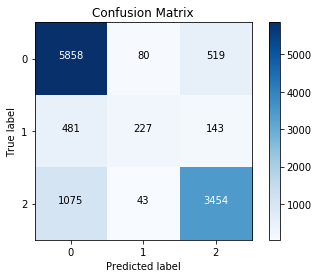

------------------------------------------------------------
test accuracy: 0.802946127946128
train accuracy: 0.8737373737373737
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84      6457
           1       0.65      0.27      0.38       851
           2       0.84      0.76      0.80      4572

    accuracy                           0.80     11880
   macro avg       0.76      0.64      0.67     11880
weighted avg       0.80      0.80      0.79     11880

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     25802
           1       0.87      0.39      0.53      3466
           2       0.92      0.84      0.88     18252

    accuracy                           0.87     47520
   macro avg       0.88      0.73      0.77     47520
weighted avg 

In [31]:
metrics('XGBoost', y_train, y_test, xgb_train_preds, xgb_test_preds)

### Evaluating XGBoost (pre-pipe)

Model: XGBoost, sub
------------------------------------------------------------


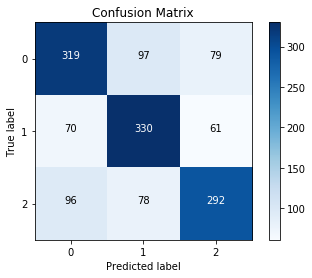

------------------------------------------------------------
test accuracy: 0.6617440225035162
train accuracy: 0.718552036199095
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65       495
           1       0.65      0.72      0.68       461
           2       0.68      0.63      0.65       466

    accuracy                           0.66      1422
   macro avg       0.66      0.66      0.66      1422
weighted avg       0.66      0.66      0.66      1422

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.69      1084
           1       0.72      0.77      0.75      1118
           2       0.75      0.68      0.71      1113

    accuracy                           0.72      3315
   macro avg       0.72      0.72      0.72      3315
weighted avg 

In [652]:
metrics('XGBoost, sub', y_train, y_test, xgb_train_preds, xgb_test_preds)

In [653]:
y_total_pipe_pred = xgboost_pipe.predict(X_total_test)

In [655]:
print(classification_report(y_total_test, y_total_pipe_pred))

              precision    recall  f1-score   support

           0       0.87      0.62      0.73      2683
           1       0.24      0.71      0.36       316
           2       0.59      0.66      0.63      1076

    accuracy                           0.64      4075
   macro avg       0.57      0.67      0.57      4075
weighted avg       0.75      0.64      0.67      4075



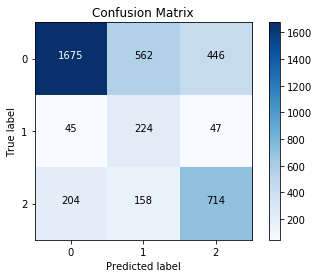

In [656]:
plot_confusion_matrix(y_total_test, y_total_pipe_pred)

### Highest Score overall, lowest recall for class 'functional needs repair'

Model: XGBoost, all data
------------------------------------------------------------


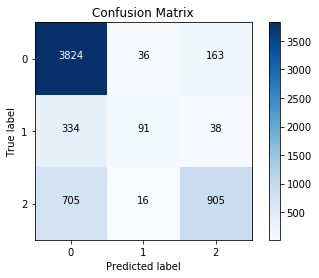

------------------------------------------------------------
test accuracy: 0.7886125654450262
train accuracy: 0.8231292517006803
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86      4023
           1       0.64      0.20      0.30       463
           2       0.82      0.56      0.66      1626

    accuracy                           0.79      6112
   macro avg       0.75      0.57      0.61      6112
weighted avg       0.78      0.79      0.77      6112

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      9389
           1       0.75      0.26      0.38      1116
           2       0.87      0.62      0.73      3754

    accuracy                           0.82     14259
   macro avg       0.81      0.62      0.67     14259
weighted avg

In [472]:
metrics('XGBoost, all data', y_total_train, y_total_test, xgb_train_preds, xgb_test_preds)

## Random Forest

### Fitting Random Forest

In [427]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

rfc_params = {
    'model__n_estimators' : [1500],      # number of decision trees to be created
    'model__criterion' : ['gini'], # function that is to be used for splitting
    'model__max_depth': [10],                # maximum depth of the trees
    'model__min_samples_split' : [20],       # minimum number of samples required in a leaf node before a split is attempted
    'model__min_samples_leaf' : [1],
    'model__bootstrap': [False],
}                   
    
#     {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
rfc_params.update(preprocessor_params)

In [428]:
rfc = { 'model': RandomForestClassifier(random_state=42), 'params': rfc_params }

rfc_test_preds, rfc_train_preds, rfc_pipeline = fit_predict(rfc, X_train, X_test, y_train, y_test)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 16.0min remaining: 24.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 22.7min finished
/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[feature_name+'_'+target_col[-1:]] = X[feature_name].map(self.mean_map[target_col])
/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Best parameter (CV score=0.746):
{'model__bootstrap': False, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 20, 'model__n_estimators': 1500}


1. gps: .581
2. year: .593
3. scheme_name: .543 <--
4. scheme_management: .536 <--
5. installer: .544
6. funder: .547
7. subvillage: .559
8. cats: .605
9. public_meeting: .601 <--
10. permit: .608
11. district_code: .593 <--
12. extraction: .600
13. mean_pumps: .604
14. no bads: .622
15. hyperparameter tune: .623

### Evaluating Random Forest

Model: Random Forest
------------------------------------------------------------


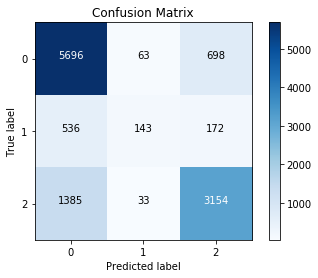

------------------------------------------------------------
test accuracy: 0.756986531986532
train accuracy: 0.8622474747474748
------------------------------------------------------------

test report:
              precision    recall  f1-score   support

           0       0.75      0.88      0.81      6457
           1       0.60      0.17      0.26       851
           2       0.78      0.69      0.73      4572

    accuracy                           0.76     11880
   macro avg       0.71      0.58      0.60     11880
weighted avg       0.75      0.76      0.74     11880

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

train report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     25802
           1       0.91      0.36      0.52      3466
           2       0.92      0.82      0.86     18252

    accuracy                           0.86     47520
   macro avg       0.89      0.71      0.76     47520
weighted avg 

In [429]:
metrics('Random Forest', y_train, y_test, rfc_train_preds, rfc_test_preds)

## Conclusion

### Top Features

In [260]:
def get_categorical():
    feature_names = []
    for key in ['high_card', 'other_high_card', 'scheme_management', 'scheme_name', 'cat', 'extraction']:
        try:
            feature_names += xgboost_pipe.best_estimator_.named_steps['preprocessor'].named_transformers_[key].named_steps['transform'].column_names.tolist()
        except:
            feature_names += list(xgboost_pipe.best_estimator_.named_steps['preprocessor'].named_transformers_[key].named_steps['onehot'].get_feature_names())
    return feature_names

In [261]:
import eli5
from sklearn.compose import ColumnTransformer

def top_feat(model_pipe):
    '''This function is used to find the best features of our models

    Args:
        model_pipe (GridSearchCV): model_pipe is a pipeline

    Returns:
        the top features of the model
    '''

    onehot_columns = get_categorical()
    numeric_features_list = list(X.drop(['id', 'amount_tsh', 'region_code'], axis=1).select_dtypes(include='number').columns)
    numeric_features_list.extend(onehot_columns)
    return eli5.explain_weights(model_pipe.best_estimator_.named_steps['model'], top=10, feature_names=numeric_features_list)

/Users/yrgg/opt/anaconda3/envs/tanzania/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/yrgg/opt/anaconda3/envs/tanzania/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [262]:
X.select_dtypes(include='number').columns

Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year'],
      dtype='object')

In [263]:
top_feat(xgboost_pipe)

KeyError: 'onehot'

Groundwater is very important to maintain the functionality of the wells. The wells are completely dependent on the different water sources, especially ground water.

We would look into different methods such as rainwater harvesting and soil conservation which would also help sustain more water in the lakes.

We see that when we make payment based on bucket or monthly payment, the wells are maintained better. So payment is an important factor.

Age of the wells is an important factor to predict the functionality of the wells. The newer the wells are, more water they have or better is their condition.

We can see that having a public meeting helps in functioning of the wells. More than 50% wells are functional when there is a public meeting held for the same. Thus, Public meeting is an important factor for the functioning of wells.

Further send out designated people to inspect the pumps detected by the model and assess what needs to be done.

### Competition

In [18]:
X_contest['predictions'] = xgboost_pipe.predict(X_contest)

/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:148: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X['latitude'] == -2e-08)]['latitude'] = X['latitude'].map(self.lat_mean_map)
/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:149: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X['longitude'] == 0)]['longitude'] = X['longitude'].map(self.long_mean_map)
/Users/yrgg/data_science/projects/tanzania/notebooks/preprocessing.py:294: SettingWithCopyWarning: 
A value is 

In [19]:
X_contest['status_group'] = X_contest['predictions'].map({ 0: 'functional', 1: 'functional needs repair', 2: 'non functional'})

In [20]:
X_contest[['id', 'status_group']].head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,non functional
3,45559,non functional
4,49871,functional


In [21]:
submission = X_contest.set_index('id')[['status_group']]
submission.to_csv('submission_05.csv')

In [110]:
f"Score: 0.7996, Rank: 1902 out of 9453 ({1-(1902/9453)})"

'Score: 0.7996, Rank: 1902 out of 9453 (0.7987940336401143)'

In [330]:
f"Score: 0.8068, Rank: 1602 out of 9476 ({1-(1602/9476)})"


'Score: 0.8068, Rank: 1602 out of 9476 (0.830941325453778)'

### Inspect the predicted values vs the actual values and find out why they are being mis-classified